In [1]:
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from myheatmap import myheatmap

import matplotlib
print(matplotlib.__version__) # version 3 required for cmap='twilight_shifted'

sns.set_context('poster') # makes text larger

add_circle = False

############### Mac vs Windows ##############
#folder = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/2019/2019/08/09/'
folder = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\2019\2019\08\09'


3.1.2


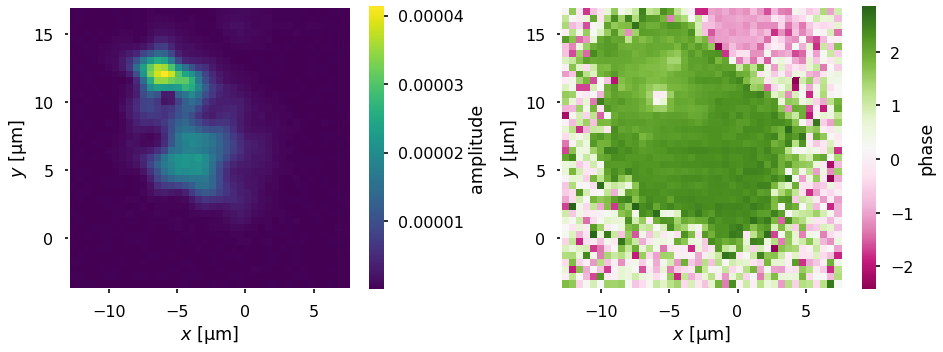

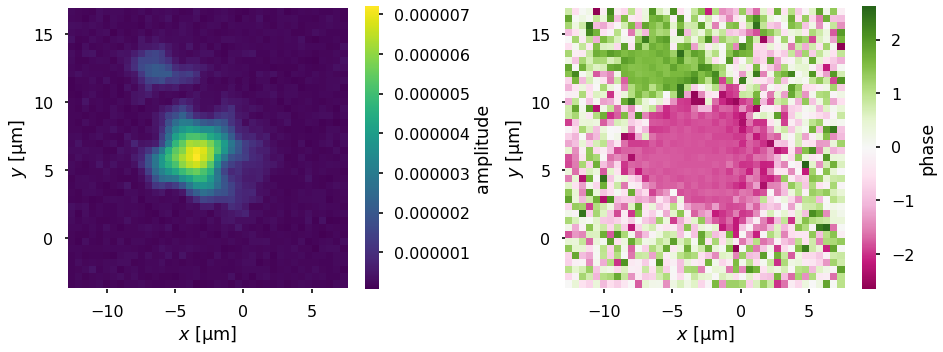

In [2]:
file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum_15.16MHz_1104325' 
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13.23,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1)
df['rlog'] = np.log10(df.r) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']
amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
myheatmap(amp1, 'amplitude', cmap = 'viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')


plt.sca(ax2)
df['rlog'] = np.log10(df.r) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase1, 'phase', cmap='PiYG');
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.tight_layout();


file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1_15.5MHz105133' 
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 


fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(13.23,5))

plt.sca(ax3)
df['rlog'] = np.log10(df.r) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']
amp2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
myheatmap(amp2, 'amplitude', cmap = 'viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax3.axis('equal');

if add_circle:
    circle1 = plt.Circle((-6.8, 7.6), 1, color='w', alpha = .3)
    circle2 = plt.Circle((-2.9,9.9), 1, color='w', alpha = .3)
    circle3 = plt.Circle((-1,5), 1, color='w', alpha = .3)
    ax3.add_artist(circle1)
    ax3.add_artist(circle2)
    ax3.add_artist(circle3)

plt.sca(ax4)
df['rlog'] = np.log10(df.r) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']
phase2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase2, 'phase', cmap='PiYG');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax4.axis('equal');

plt.tight_layout();

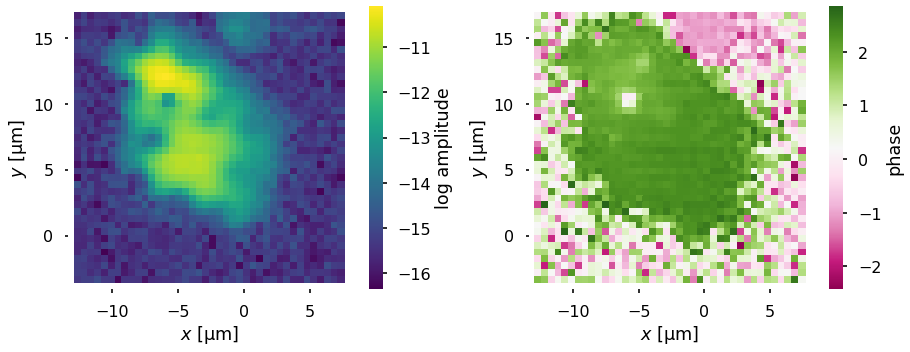

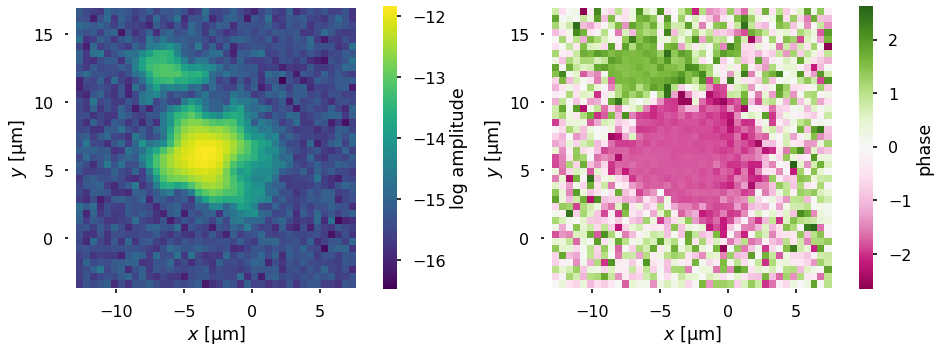

In [10]:
file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum_15.16MHz_1104325' 
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1)
df['rlog'] = np.log10(df.r) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']
amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
myheatmap(np.log(amp1), 'log amplitude', cmap = 'viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')


plt.sca(ax2)
df['rlog'] = np.log10(df.r) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase1, 'phase', cmap='PiYG');
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.tight_layout();


file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1_15.5MHz105133' 
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 


fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(13.23,5))

plt.sca(ax3)
df['rlog'] = np.log10(df.r) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']
amp2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
myheatmap(np.log(amp2), 'log amplitude', cmap = 'viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax3.axis('equal');

if add_circle:
    circle1 = plt.Circle((-6.8, 7.6), 1, color='w', alpha = .3)
    circle2 = plt.Circle((-2.9,9.9), 1, color='w', alpha = .3)
    circle3 = plt.Circle((-1,5), 1, color='w', alpha = .3)
    ax3.add_artist(circle1)
    ax3.add_artist(circle2)
    ax3.add_artist(circle3)

plt.sca(ax4)
df['rlog'] = np.log10(df.r) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']
phase2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase2, 'phase', cmap='PiYG');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax4.axis('equal');

plt.tight_layout();